In [418]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import scipy.signal
import matplotlib.ticker as plticker
import time
from mpl_toolkits.axes_grid1 import make_axes_locatable
from tqdm import tqdm
from collections import defaultdict
from typing import Optional
from scipy.integrate import solve_ivp
from scipy.fftpack import diff as psdiff
import torch
import pytorch_lightning as pl
from torch import nn
import logging
import copy

import os, sys
sys.path.append(os.path.join(os.getcwd(), '../sympde'))

from data.dataset import PDEDataset, PDEDataModule
from data.pdes import PDEs
from data.utils import d_to_LT
from misc.utils import load_obj

from model.setup import setup_model
from model.networks.fno import FNO1d
from model.networks.cnn import CNN, ResNet, BasicBlock1d, ResNet_conv
from model.learner import Learner

from model.networks.fno import FNO1d

from viz.plot_pde_data import plot_1ds, plot_1d_dict
from misc.utils import load_obj, save_obj

from run import parse_options, main

from model.networks.single_sym.magnitude import Conv1dMag, Conv2dMag
from misc.equiv import assert_equiv
from lconv.convs import MyConv1d
from lconv.mlp import MyLinear
from misc.equiv import allclose_flat, check

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [429]:
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)
logging.debug("test")

args = parse_options(notebook=True)
args.train = True
args.pde_name = 'KdV'
args.data_dir = '../data/test'
args.net = 'MLPFlat'
args.max_epochs = 3
args.batch_size = 4
args.num_workers = 0
args.persistent_workers = False
args.verion = None
args.do_return = True
args.mlp_hidden_channels = [100, 100, 100]
args.mlp_hidden_channels = [256*6, 256*4, 100*3]
args.embed_spacetime = False

args.seed = 2
args.epsilons = [0., 0., 0., 0.]

model, trainer, datamodule = main(args)
model.eval();

DEBUG:root:test
Seed set to 2
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs




###	Version:  None 	###
###	Name:  datatest_netMLPFlat_equivnone_KdV_aug0.0-0.0-0.0-0.0_seed2_mlp1536-1024-300 	###


Selecting 10 out of the 10 train samples!
Augmenting KdV with epsilons [0.0, 0.0, 0.0, 0.0]!
Selecting 2 out of the 2 val samples!
Selecting 2 out of the 2 test samples!


In [451]:
256*6, 256*4, 100*3, 
2**16, 2**13, 2**8

(65536, 8192, 256)

In [430]:
tol = 1e-5

In [431]:
dataloader = datamodule.train_dataloader()
dataset = datamodule.dataset['train']
batch = us, dxs, dts = next(iter(dataloader))

model(batch);

In [432]:


rand = False

def augment_none(batch_i, dataset = dataset, epsilons = [0, 0., 0., 0.]):
    assert dataset.epsilons == [0, 0., 0., 0.] == epsilons
    return batch_i

def augment_space(batch_i, dataset = dataset, epsilons = [0, .5, 0., 0.]):
    assert dataset.epsilons == [0, 0., 0., 0.]
    return dataset.augment(*batch_i, epsilons, rand=rand)
    u, dx, dt = batch_i
    space_cut = int(epsilons[1] * u.shape[1])
    u_tranfs = torch.cat((u[:, space_cut:], u[:, :space_cut]), axis=1)
    return u_tranfs, dx, dt

def augment_galileo(batch_i, dataset = dataset, epsilons = [0, 0., .5, 0.0]):
    assert dataset.epsilons == [0, 0., 0., 0.]
    return dataset.augment(*batch_i, epsilons, rand=rand)

def augment_scale(batch_i, dataset = dataset, epsilons = [0, 0., 0., 0.5]):
    assert dataset.epsilons == [0, 0., 0., 0.]
    return dataset.augment(*batch_i, epsilons, rand=rand)

def augment_batch(batch, augment):
    us_aug, dxs_aug, dts_aug = [], [], []
    us, dxs, dts = batch
    for u, dx, dt in zip(us, dxs, dts):
        batch_i = u, dx, dt
        u_aug, dx_aug, dt_aug = augment(batch_i)
        us_aug.append(u_aug)
        dxs_aug.append(dx_aug)
        dts_aug.append(dt_aug)

    us_augs = torch.stack(us_aug)
    dxs_augs = torch.stack(dxs_aug)
    dts_augs = torch.stack(dts_aug)
    return us_augs, dxs_augs, dts_augs    

def augment_batch_none(batch):
    return augment_batch(batch, augment_none)

def augment_batch_space(batch):
    return augment_batch(batch, augment_space)

def augment_batch_galileo(batch):
    return augment_batch(batch, augment_galileo)

def augment_batch_scale(batch):
    return augment_batch(batch, augment_scale)

augments = {'none':augment_batch_none, 'space':augment_batch_space, 'galileo':augment_batch_galileo, 'scale':augment_batch_scale}
batches = {augment : augment_func(batch) for augment, augment_func in augments.items()}

In [433]:
# for augment, batch in batches.items():
#     plot_1ds(*batch, nrows=1, ncols = len(us), l = 0.3, title = augment)

In [434]:
# class LearnerWrapper(Learner):
#     def __init__(self, *args, **kwargs):
#         super().__init__(*args, **kwargs)
#         self.model.eval()
#         self.return_pred = False
    
#     def forward(self, batch):
#         return self.model(batch, return_pred = self.return_pred)
    
# model_wrapped = LearnerWrapper(model, trainer, datamodule)

In [435]:
model(batch);
model.net

MLPFlat(
  (mlp): MLP(
    (0): Linear(in_features=2560, out_features=1536, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.0, inplace=False)
    (3): Linear(in_features=1536, out_features=1024, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.0, inplace=False)
    (6): Linear(in_features=1024, out_features=300, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.0, inplace=False)
    (9): Linear(in_features=300, out_features=1280, bias=True)
    (10): Dropout(p=0.0, inplace=False)
  )
)

In [437]:
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
model_parameters, params

(<filter at 0x2893518d0>, 6200364)

In [407]:

postprocess = lambda batch: batch[0]

for augment, augment_func in augments.items():
    print(f'\n{augment}')
    assert_equiv(batches['none'], model, augment_func, rtol=tol, atol=tol, postprocess=postprocess, print_only=True);


none
Equivariance test passed.

space
Equivariance test passed.

galileo
Equivariance test failed. 
Max difference:  0.692234 
Mean difference: 0.505042

scale
Equivariance test failed. 
Max difference:  1.01834 
Mean difference: 0.367973


## Conv1d

In [408]:
batch_size, width = 1, 256
in_channels, out_channels = 40, 40
kernel_size, stride = 3, 1

x = torch.randn(batch_size, in_channels, width)
padding = (kernel_size - 1) // 2

padding_mode = 'circular'
bias = False

# Create conv
conv_torch = nn.Conv1d(in_channels, out_channels, kernel_size, stride=stride, bias=bias, padding=padding, padding_mode=padding_mode)
out_true = conv_torch(x)

conv = MyConv1d(in_channels, out_channels, kernel_size, stride=stride, bias=bias, padding=padding, padding_mode=padding_mode)
conv.weights = nn.Parameter(conv_torch.weight)
conv.biases = nn.Parameter(conv_torch.bias)
out = conv(x)

assert torch.allclose(out_true, out, atol=tol, rtol=tol)
assert torch.allclose(out_true, out) # For some reason, this fails. TODO: Find out why

In [409]:
class ConvModel(nn.Module):
    def __init__(
        self,
        convmodule,
        in_channels,
        out_channels,
        kernel_size,
        stride = stride,
        bias = bias,
        padding = padding,
        padding_mode = padding_mode
    ):
        super().__init__()
        assert convmodule in [nn.Conv1d, MyConv1d]
        # convmodule = nn.Conv1d
        self.conv = convmodule(in_channels, out_channels, kernel_size, stride=stride, bias=bias, padding=padding, padding_mode=padding_mode)
        # self.weights = nn.Parameter(conv_torch.weight)
        # self.biases = nn.Parameter(conv_torch.bias)

    def forward(self, batch):
        us, dxs, dts = batch
        us = self.conv(us)
        return us, dxs, dts
    
conv = ConvModel(
    convmodule = MyConv1d,
    in_channels = in_channels,
    out_channels = out_channels,
    kernel_size = kernel_size,
    stride = stride,
    bias = bias,
    padding = padding,
    padding_mode = padding_mode
)
conv.eval()

postprocess = lambda batch: batch[0]

for augment, augment_func in augments.items():
    print(f'\n{augment}')
    assert_equiv(batches['none'], conv, augment_func, rtol=tol, atol=tol, postprocess=postprocess, print_only=True);


none
Equivariance test passed.

space
Equivariance test failed. 
Max difference:  4.19617e-05 
Mean difference: 1.78926e-06

galileo
Equivariance test failed. 
Max difference:  102.441 
Mean difference: 8.22378

scale
Equivariance test failed. 
Max difference:  0.000335693 
Mean difference: 1.03104e-05


## MLP

In [410]:
batches['none']

(tensor([[[-0.9970, -0.9977, -0.9972,  ..., -0.9873, -0.9918, -0.9950],
          [-0.9956, -0.9927, -0.9886,  ..., -0.9968, -0.9977, -0.9973],
          [-0.9840, -0.9777, -0.9704,  ..., -0.9957, -0.9930, -0.9891],
          ...,
          [-0.3301, -0.3269, -0.3245,  ..., -0.3482, -0.3407, -0.3346],
          [-0.3358, -0.3346, -0.3324,  ..., -0.3417, -0.3387, -0.3369],
          [-0.3450, -0.3407, -0.3335,  ..., -0.3476, -0.3476, -0.3470]],
 
         [[ 0.1958,  0.2506,  0.3069,  ...,  0.0413,  0.0911,  0.1426],
          [ 0.1736,  0.2212,  0.2700,  ...,  0.0375,  0.0816,  0.1270],
          [ 0.1560,  0.1983,  0.2413,  ...,  0.0344,  0.0740,  0.1146],
          ...,
          [ 1.2052,  1.8055,  1.8959,  ..., -0.3885, -0.0517,  0.5505],
          [ 1.9078,  1.9438,  1.3614,  ..., -0.2107,  0.5018,  1.3636],
          [ 1.4616,  1.2252,  0.8277,  ...,  0.6614,  1.1807,  1.5265]],
 
         [[-0.8128, -0.8299, -0.8460,  ..., -0.7564, -0.7761, -0.7949],
          [-0.8514, -0.8669,

In [412]:
class LinearModel(nn.Module):
    def __init__(
        self,
        linearmodule,
        in_features, 
        out_features, 
        bias=True,
        transform_type = 'none',
    ):
        super().__init__()
        self.time_history = in_features
        self.time_future = out_features
        assert linearmodule in [nn.Linear, MyLinear]
        if linearmodule == nn.Linear:
            self.linear = linearmodule(in_features, out_features, bias)
        else:
            self.linear = linearmodule(in_features, out_features, bias, transform_type)
        # self.weights = nn.Parameter(conv_torch.weight)
        # self.biases = nn.Parameter(conv_torch.bias)

    def forward(self, us, dxs, dts):
        # print(us.shape)
        out = self.linear(us)
        return out
    
linear = LinearModel(
    # linearmodule = nn.Linear,
    linearmodule = MyLinear,
    in_features = 10,
    out_features = 5,
    bias = True,
    transform_type = 'none',
)

model = Learner(net=linear, criterion = None)

postprocess = lambda batch: batch[0]

for augment, augment_func in augments.items():
    print(f'\n{augment}')
    assert_equiv(batch, model, augment_func, rtol=tol, atol=tol, postprocess=postprocess, print_only=True);


none
Equivariance test passed.

space
Equivariance test passed.

galileo
Equivariance test failed. 
Max difference:  26.6179 
Mean difference: 2.15132

scale
Equivariance test failed. 
Max difference:  9.32444 
Mean difference: 5.22574


In [413]:
10*256

2560

torch.Size([4, 256, 10])
torch.Size([4, 256, 5])


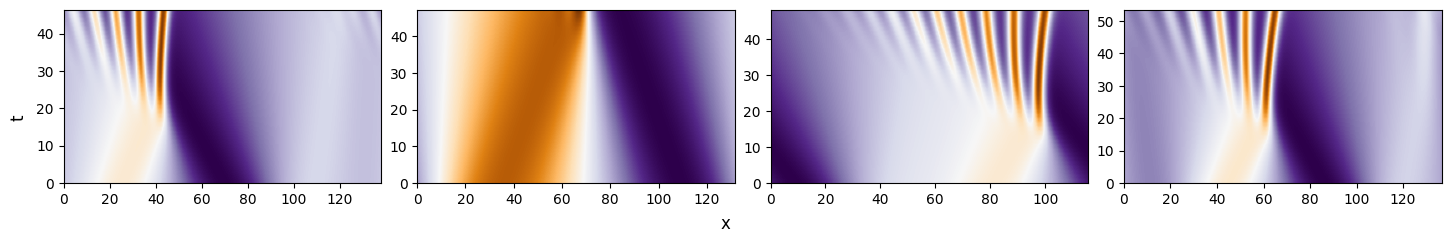

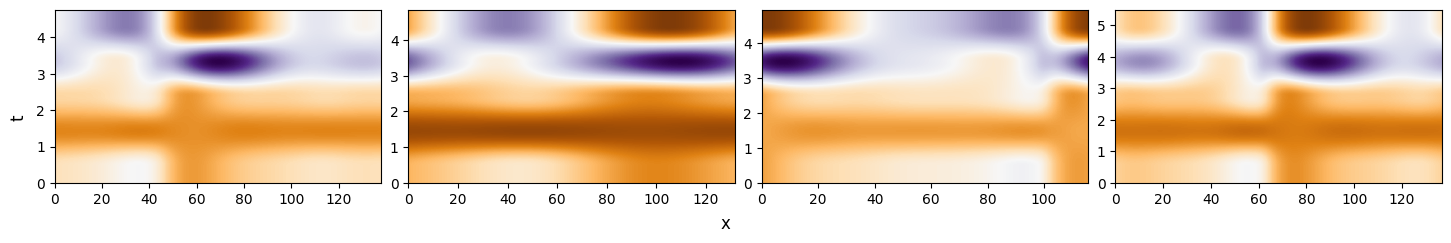

In [392]:
batch_org = copy.deepcopy(batch)

us, dxs, dts = batch_org
# us[0, :, :100] = 0
y_pred, dxs, dts = model((us, dxs, dts))

plot_1ds(us.detach().numpy(), dxs.detach().numpy(), dts.detach().numpy(), nrows=1,ncols=len(us), l = .3)
plot_1ds(y_pred.detach().numpy(), dxs.detach().numpy(), dts.detach().numpy(), nrows=1,ncols=len(us), l = .3)

DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.AutoLocator object at 0x291d82350>


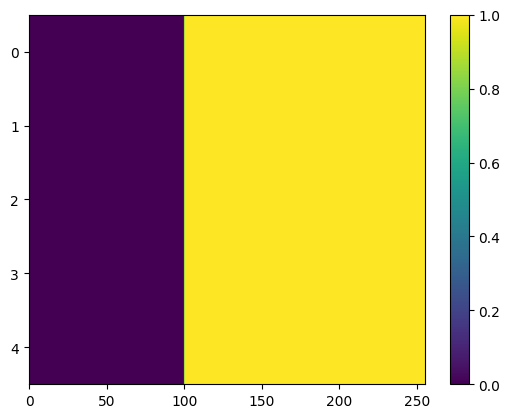

In [397]:
plt.imshow(y_pred[0] == y2[0], aspect='auto')
plt.colorbar()

In [391]:
y2 = y_pred.detach().clone()

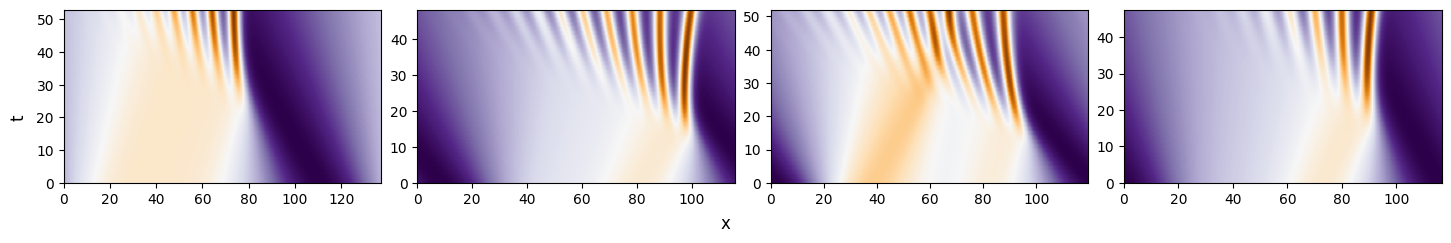

In [332]:
linear.linear.w.shape

torch.Size([5, 10])

In [ ]:


batch_size = 2
in_features, out_features = 5, 5
bias = True

x = torch.randn(batch_size, in_features)

linear_torch = nn.Linear(in_features, out_features, bias)
out_torch = linear_torch(x)

linear = MyLinear(in_features, out_features, bias)
linear.w = nn.Parameter(linear_torch.weight)
linear.b = nn.Parameter(linear_torch.bias)
out = linear(x)

assert torch.allclose(out_torch, out)


In [ ]:
# assert out_features == in_features
# eye = torch.eye(out_features, in_features)
# w2 = torch.sum(torch.stack([transform(eye*(i+1), shift) for i, shift in enumerate(range(in_features))]), dim=0)
# w2

In [ ]:
def transform(x, shift = 1):
    assert len(x.shape) == 2 # batch_size, in_features
    # return torch.roll(x, shifts=shift, dims=1)

    return x * torch.exp(-torch.tensor(shift))

In [ ]:
batch_size = 2
in_features, out_features = 5, 5
bias = True

x = torch.randn(batch_size, in_features)
linear = MyLinear(in_features, out_features, bias, transform_type='scaling')

In [ ]:
plots = [x, transform(x), linear(transform(x)), x, linear(x), transform(linear(x))]
titles = ['x', 'transform(x)', 'linear(transform(x))', 'x', 'linear(x)', 'transform(linear(x))']

fig, axs = plt.subplots(2, 3, figsize=(10, 3), tight_layout=True)
axs = axs.flatten()

for i, ax in enumerate(axs):
    ax.imshow(plots[i].detach().numpy())
    ax.set_title(titles[i])
    ax.axis('off')
plt.show()

assert_equiv(x, linear, transform, print_only=True);